## RFM Analysis - Customer Segmentation

**Customer Segmentation** is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors.

**RFM (Recency-Frequency-Monetary)** analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

The goal of this analysis is to identify customer segments for global retail company using RFM analysis and to understand how those groups differ from each other.

In [30]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import warnings
import json
warnings.filterwarnings("ignore")

### Load Dataset

In [31]:
file = r"C:\Ayub Indra\Data Analyst\DSLS 2023\Data Engineering\Mini Project\Objective 3 - RFM Analysis\[Dataset] RFM Analysis.xlsx"

df = pd.read_excel(file)

df.head()

,OrderID,Order Date,Shipped Date,Customer Name,Country,Product Name,Product Category,Unit Sold,Sales
0,10400,1997-01-01,1997-01-16,Eastern Connection,UK,Thüringer Rostbratwurst,Meat/Poultry,21,2079
1,10400,1997-01-01,1997-01-16,Eastern Connection,UK,Steeleye Stout,Beverages,35,504
2,10400,1997-01-01,1997-01-16,Eastern Connection,UK,Maxilaku,Confections,30,480
3,10401,1997-01-01,1997-01-10,Rattlesnake Canyon Grocery,USA,Nord-Ost Matjeshering,Seafood,18,372
4,10401,1997-01-01,1997-01-10,Rattlesnake Canyon Grocery,USA,Gnocchi di nonna Alice,Grains/Cereals,70,2128


In [32]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OrderID           1059 non-null   int64         
 1   Order Date        1059 non-null   datetime64[ns]
 2   Shipped Date      1059 non-null   datetime64[ns]
 3   Customer Name     1059 non-null   object        
 4   Country           1059 non-null   object        
 5   Product Name      1059 non-null   object        
 6   Product Category  1059 non-null   object        
 7   Unit Sold         1059 non-null   int64         
 8   Sales             1059 non-null   int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 74.6+ KB


**Data Dictionary**
- OrderID : Unique order number
- Order Date : Date when order taken
- Shipped Date : Date when unit / product shipped to the customer site
- Customer Name : Company name of customer
- Country : Country that located of customer
- Product Name : Product sold
- Product Category : Category of product sold
- Unit Sold : Quantity of product sold
- Sales : Unit Sold x Unit Price

### Calculating RFM

RFM model combines three different customer attributes to rank customers:

Recency (R): Who have purchased recently? Number of days since last purchase
Frequency (F): Who has purchased frequently? The total number of purchases
Monetary Value(M): Who has high purchase amount? The total money customer spent
If the customer bought in recent past, he gets higher points. If he bought many times, he gets higher score. And if he spent a lot of money, he gets more points.

How to create segments?

Concatenate all scores into one, eg: 3-4-1 (R-F-M) and group customers according to those values. It gives 125 combinations which is difficult to depict and understand
Sum all scores into one, eg: 8 (3 + 4 + 1) and group customers according to this number. It creates 13 groups which is much easier to work with but it disregards relations between R & F & M
Segment customers based on set of rules applied to R-F-M scores. It creates 10 groups, such as "champions", "needing attention" or "at risk"

In [33]:
# Calculating Recency

df_recency = df.groupby(by="Customer Name", as_index=False)["Order Date"].max().sort_values(by="Order Date", ascending=False)
df_recency.columns = ["Customer Name", "Last Purchase Date"]
recent_date = df_recency["Last Purchase Date"].max()
df_recency["Recency"] = df_recency["Last Purchase Date"].apply(lambda x: (recent_date - x).days)
df_recency.head()

,Customer Name,Last Purchase Date,Recency
79,Victuailles en stock,1997-12-31,0
24,Franchi S.p.A.,1997-12-31,0
72,The Big Cheese,1997-12-30,1
82,Wellington Importadora,1997-12-30,1
67,Seven Seas Imports,1997-12-30,1


In [34]:
# Calculating Frequency

df_frequency = df.drop_duplicates().groupby(by="Customer Name", as_index=False)["OrderID"].count().sort_values(by="OrderID",ascending=False)
df_frequency.columns = ["Customer Name", "Frequency"]
df_frequency.head()

,Customer Name,Frequency
66,Save-a-lot Markets,64
57,QUICK-Stop,44
19,Ernst Handel,44
81,Wartian Herkku,28
5,Berglunds snabbköp,27


In [35]:
# Calculating Monetary

df_monetary = df.groupby(by="Customer Name", as_index=False)["Sales"].sum().sort_values(by="Sales", ascending=False)
df_monetary.columns = ["Customer Name", "Monetary"]
df_monetary.head()

,Customer Name,Monetary
57,QUICK-Stop,64214
66,Save-a-lot Markets,60645
19,Ernst Handel,53440
49,Mère Paillarde,26075
35,Hungry Owl All-Night Grocers,23943


In [36]:
# Merging into one df

df_rf = df_recency.merge(df_frequency, on="Customer Name")
df_rfm = df_rf.merge(df_monetary, on="Customer Name").drop(columns="Last Purchase Date")
df_rfm.head()

,Customer Name,Recency,Frequency,Monetary
0,Victuailles en stock,0,12,6093
1,Franchi S.p.A.,0,6,248
2,The Big Cheese,1,4,2955
3,Wellington Importadora,1,11,4709
4,Seven Seas Imports,1,14,9588


In [37]:
# Labelling

r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

df_rfm['R_score'] = pd.qcut(df_rfm['Recency'], q=5, labels=r_labels).astype(int)
df_rfm['F_score'] = pd.qcut(df_rfm['Frequency'], q=5, labels=f_labels).astype(int)
df_rfm['M_score'] = pd.qcut(df_rfm['Monetary'], q=5, labels=m_labels).astype(int)

df_rfm['RFM_sum'] = df_rfm['R_score'] + df_rfm['F_score'] + df_rfm['M_score']

In [38]:
df_rfm.head()

,Customer Name,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_sum
0,Victuailles en stock,0,12,6093,5,3,3,11
1,Franchi S.p.A.,0,6,248,5,2,1,8
2,The Big Cheese,1,4,2955,5,1,2,8
3,Wellington Importadora,1,11,4709,5,3,3,11
4,Seven Seas Imports,1,14,9588,5,4,4,13


In [39]:
def assign_label(df, r_rule, fm_rule, label, colname='RFM_label'):
    df.loc[(df['R_score'].between(r_rule[0], r_rule[1]))
            & (df['F_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [40]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'Champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'Loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'Potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'New customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'Promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'Needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'About to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'At risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'Cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'Hibernating')

In [41]:
df_rfm

,Customer Name,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_sum,rfm_label,RFM_label
0,Victuailles en stock,0,12,6093,5,3,3,11,,Potential loyalist
1,Franchi S.p.A.,0,6,248,5,2,1,8,,Potential loyalist
2,The Big Cheese,1,4,2955,5,1,2,8,,New customers
3,Wellington Importadora,1,11,4709,5,3,3,11,,Potential loyalist
4,Seven Seas Imports,1,14,9588,5,4,4,13,,Champions
...,...,...,...,...,...,...,...,...,...,...
81,Océano Atlántico Ltda.,237,3,429,1,1,1,3,,Hibernating
82,Pericles Comidas clásicas,265,7,2063,1,2,2,5,,Hibernating
83,Comércio Mineiro,273,3,1128,1,1,1,3,,Hibernating
84,Princesa Isabel Vinhos,289,4,1521,1,1,2,4,,Hibernating


### RFM Customer Segments

- **Champions** - bought recently, buy often and spend the most
- **Loyal Customers** - spend good money and often, responsive to promotions
- **Potential Loyalist** - recent customers, but spent a good amount and bought more than once
- **New Customers** - bought most recently, but not often
- **Promising** - recent shoppers, but haven’t spent much
- **Needing Attention** - above average recency, frequency and monetary values; may not have bought very recently though
- **About To Sleep** - below average recency, frequency and monetary values; will lose them if not reactivated
- **At Risk** - spent big money and purchased often but long time ago; need to bring them back
- **Can't Loose Them** - made biggest purchases, and often but haven’t returned for a long time
- **Hibernating** - last purchase was long back, low spenders and low number of orders

### Distribution of Recency, Frequency, Monetary

**Recency** distribution is right-skewed, showing that the majority of customers made a purchase in the recent past. It has a long tail containing single customers who made their order long time ago.

Both **frequency** and **monetary** distributions are bimodal (with two different peaks - modes). The chart reveals that one group of customers has low frequency (small number of orders, around 10 per customer) and another group is much more "loyal" (with around 50 purchases per customer). When it comes to monetary, it follows similar pattern. Part of customers have only spent little amount of money but there is another (significant in size) group that have spent much more.

**Frequency** and **monetary** distributions suggest that there are visible differences between different groups of customers. By looking at the distribution of three the biggest segments: "loyal customers", "hibernating", "potential loyalist" it's easy to see that indeed they build up different parts of total distribution, eg. hibernating customers are responsible for first monetary peak and loyal customers for the second peak.

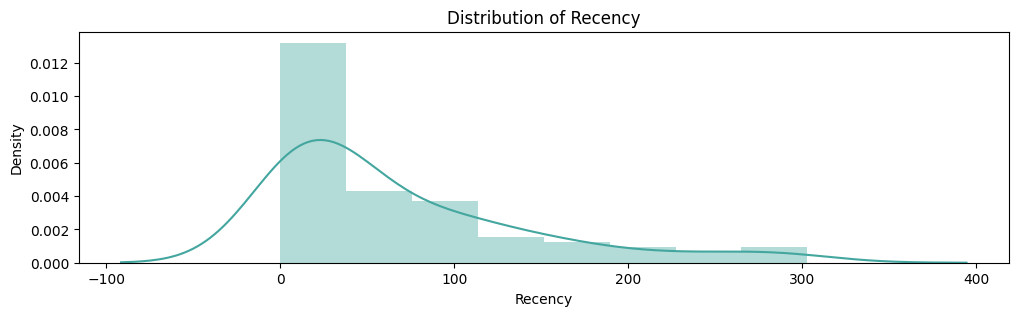

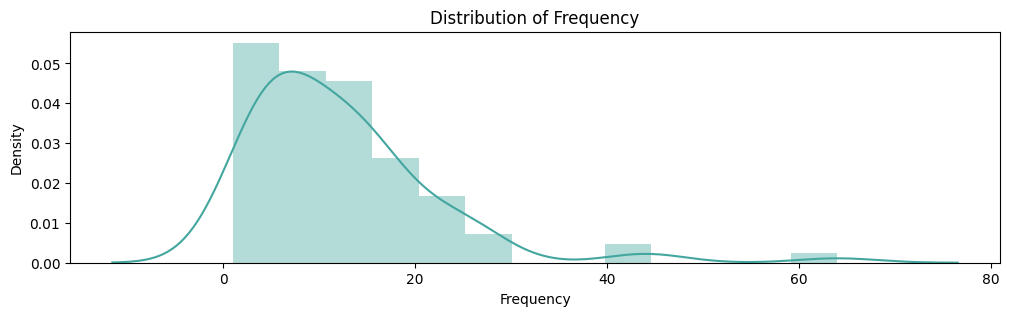

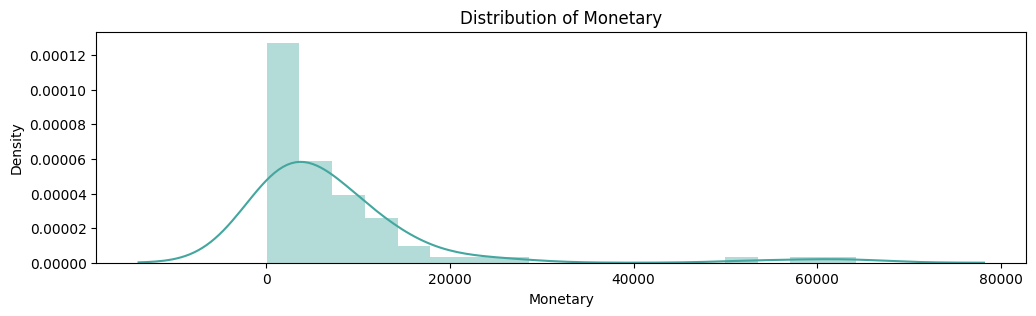

In [42]:
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(df_rfm[col], color='#43a69f')
    ax.set_title('Distribution of %s' % col)
    plt.show()

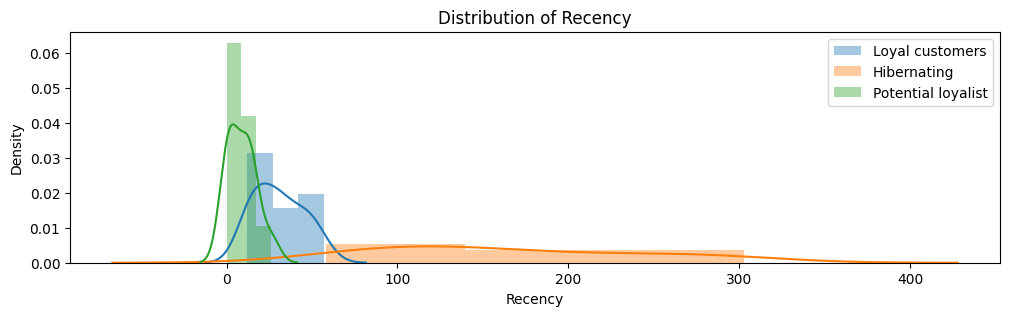

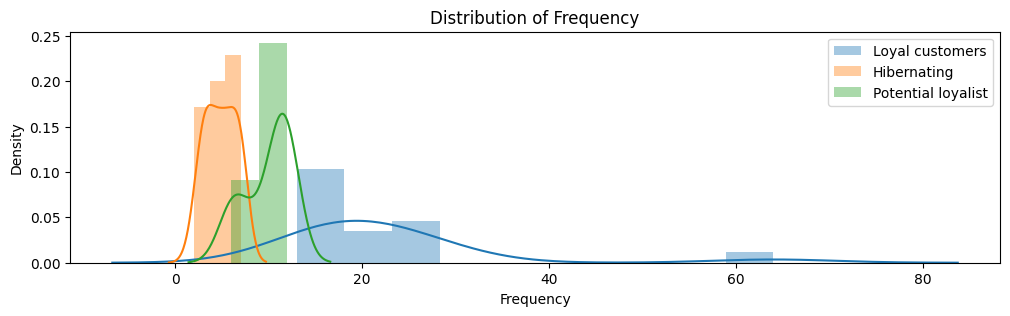

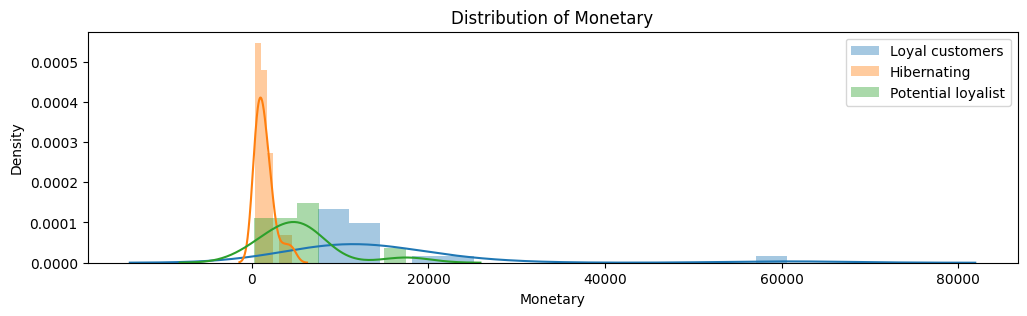

In [43]:
# Segment Distribution

segments = ['Loyal customers', 'Hibernating', 'Potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(df_rfm[df_rfm['RFM_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

### Analysis of RFM Segments

In [66]:
df_rfm

,Customer Name,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_sum,rfm_label,RFM_label
0,Victuailles en stock,0,12,6093,5,3,3,11,,Potential loyalist
1,Franchi S.p.A.,0,6,248,5,2,1,8,,Potential loyalist
2,The Big Cheese,1,4,2955,5,1,2,8,,New customers
3,Wellington Importadora,1,11,4709,5,3,3,11,,Potential loyalist
4,Seven Seas Imports,1,14,9588,5,4,4,13,,Champions
...,...,...,...,...,...,...,...,...,...,...
81,Océano Atlántico Ltda.,237,3,429,1,1,1,3,,Hibernating
82,Pericles Comidas clásicas,265,7,2063,1,2,2,5,,Hibernating
83,Comércio Mineiro,273,3,1128,1,1,1,3,,Hibernating
84,Princesa Isabel Vinhos,289,4,1521,1,1,2,4,,Hibernating


In [74]:
segments = df_rfm.groupby("RFM_label")["Customer Name", "RFM_sum"].agg({"Customer Name":"nunique", "RFM_sum":"mean"}).sort_values(by="RFM_sum", ascending=False).reset_index()
segments.columns = ["RFM Segments", "Customer Count", "RFM Mean"]

In [75]:
segments

,RFM Segments,Customer Count,RFM Mean
0,Champions,10,14.000000
1,Loyal customers,17,12.647059
2,Cant loose them,1,12.000000
3,Potential loyalist,11,10.272727
4,Needing attention,2,9.500000
5,At risk,12,8.333333
6,New customers,3,8.000000
7,Promising,3,6.333333
8,About to sleep,6,5.666667
9,Hibernating,21,4.333333


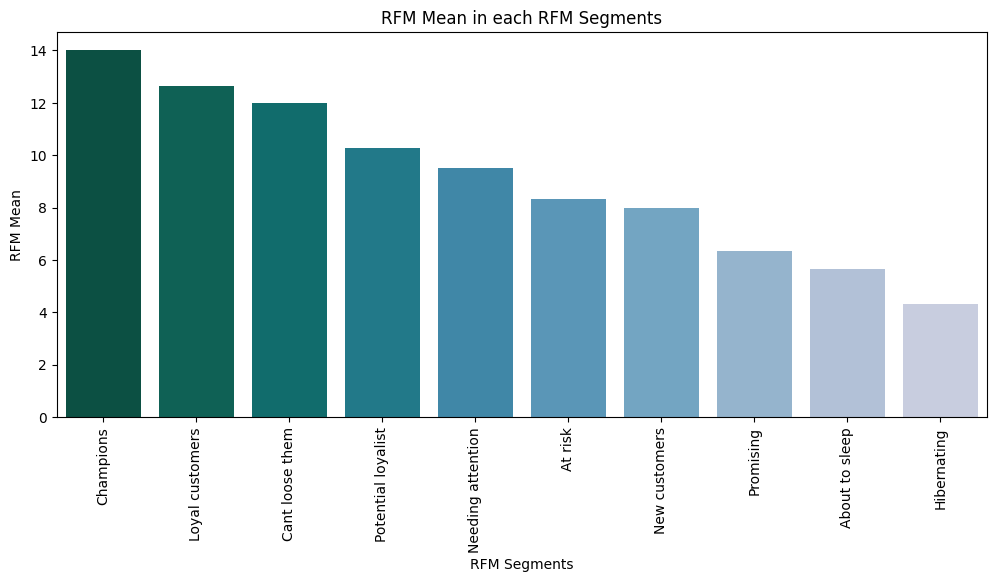

In [85]:
palette = sns.color_palette("PuBuGn", n_colors=13)
palette.reverse()
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="RFM Segments", y="RFM Mean", data=segments, palette=palette)
ax.set_title('RFM Mean in each RFM Segments')
plt.xticks(rotation=90)
plt.show()

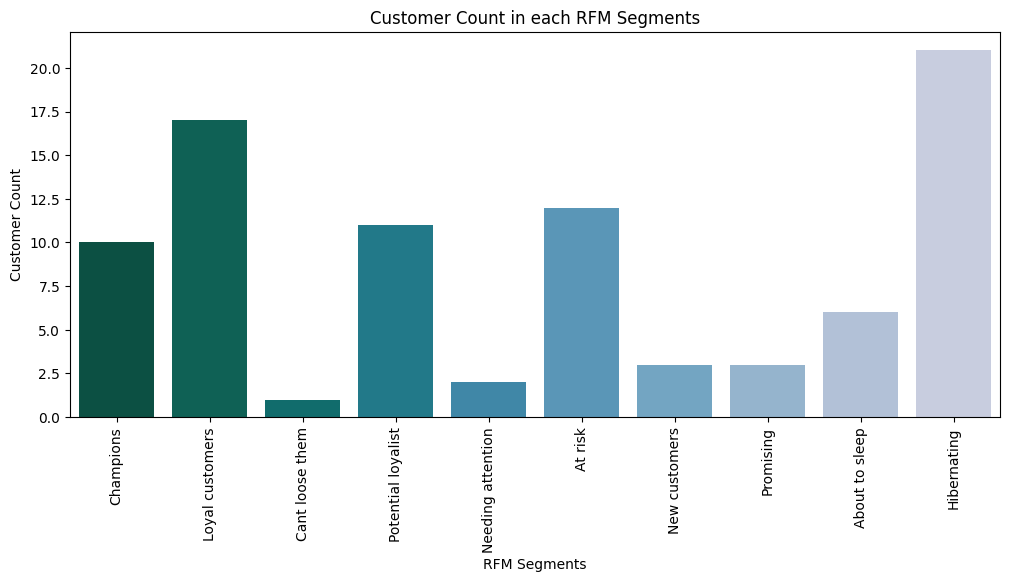

In [86]:
palette = sns.color_palette("PuBuGn", n_colors=13)
palette.reverse()
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="RFM Segments", y="Customer Count", data=segments, palette=palette)
ax.set_title('Customer Count in each RFM Segments')
plt.xticks(rotation=90)
plt.show()

In [45]:
agg_dict2 = {
    'Customer Name': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum'
}

df_analysis = df_rfm.groupby('RFM_label').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'RFM_label': 'Label', 'Customer Name': 'Count'}, axis=1, inplace=True)
df_analysis['Count share'] = df_analysis['Count'] / df_analysis['Count'].sum()
df_analysis['Monetary share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['Count']

In [46]:
df_analysis

,Label,Count,Recency,Frequency,Monetary,Count share,Monetary share
0,New customers,3,3.000000,2.333333,2469.666667,0.034884,0.011261
1,Champions,10,6.800000,23.200000,19365.800000,0.116279,0.294350
2,Potential loyalist,11,8.909091,9.909091,5438.454545,0.127907,0.090928
3,Promising,3,15.333333,3.666667,748.000000,0.034884,0.003411
4,Loyal customers,17,30.470588,22.529412,15117.000000,0.197674,0.390610
5,Needing attention,2,36.000000,8.500000,6167.500000,0.023256,0.018749
6,About to sleep,6,42.166667,4.500000,1139.500000,0.069767,0.010392
7,Cant loose them,1,62.000000,25.000000,26075.000000,0.011628,0.039633
8,At risk,12,105.166667,12.166667,5211.833333,0.139535,0.095061
9,Hibernating,21,163.666667,4.857143,1428.809524,0.244186,0.045606


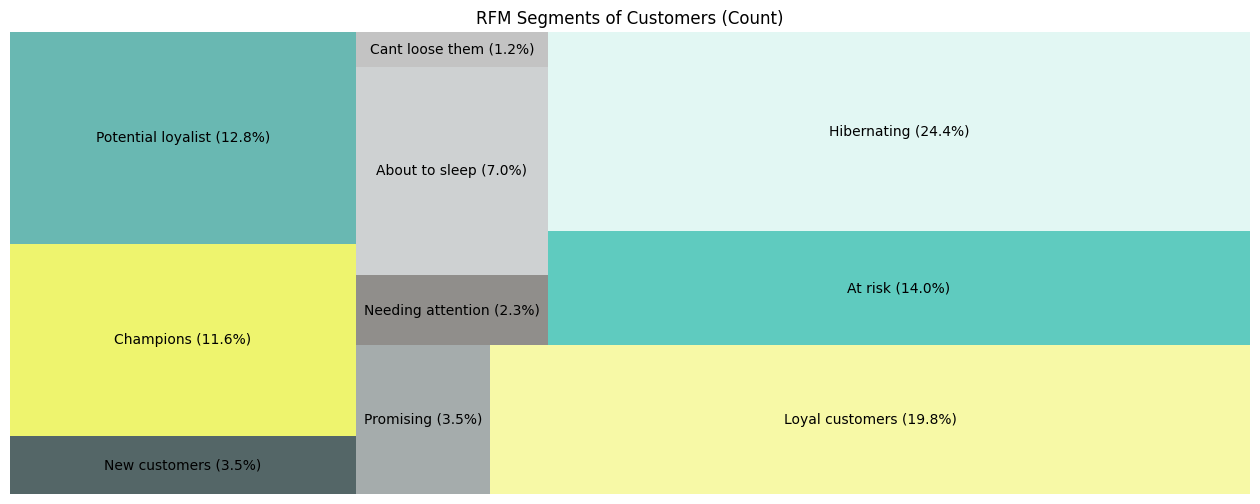

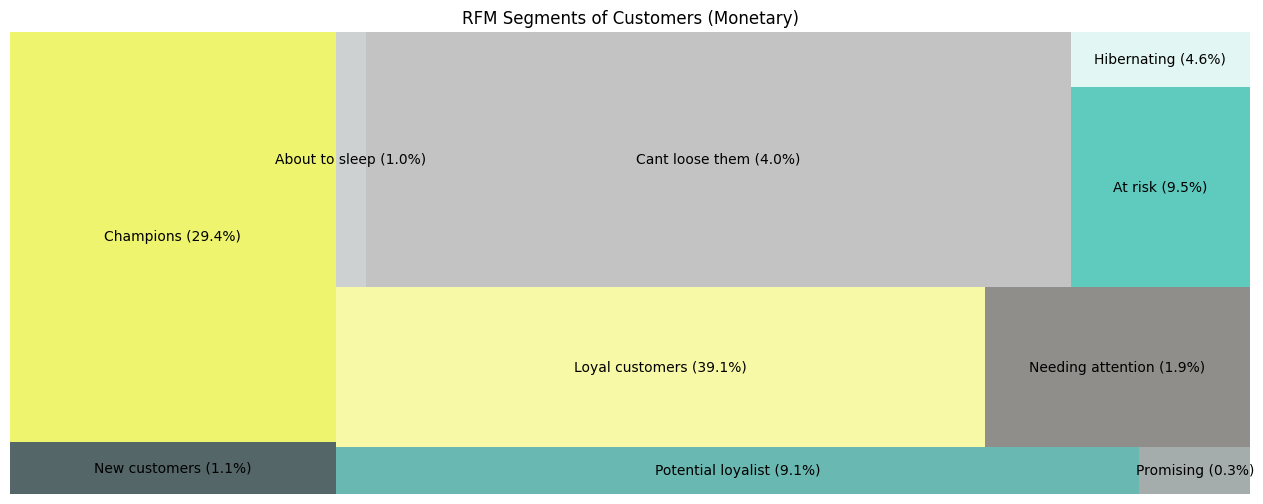

In [47]:
colors = ['#294041', '#eaf24a', '#43a69f', '#8f9797', '#f5f890', '#74726e', '#c2c6c7', '#b4b4b4', '#37BEB0', '#DBF5F0', '#41729F']

for col in ['Count', 'Monetary']:
    labels = df_analysis['Label'] + df_analysis[col + ' share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

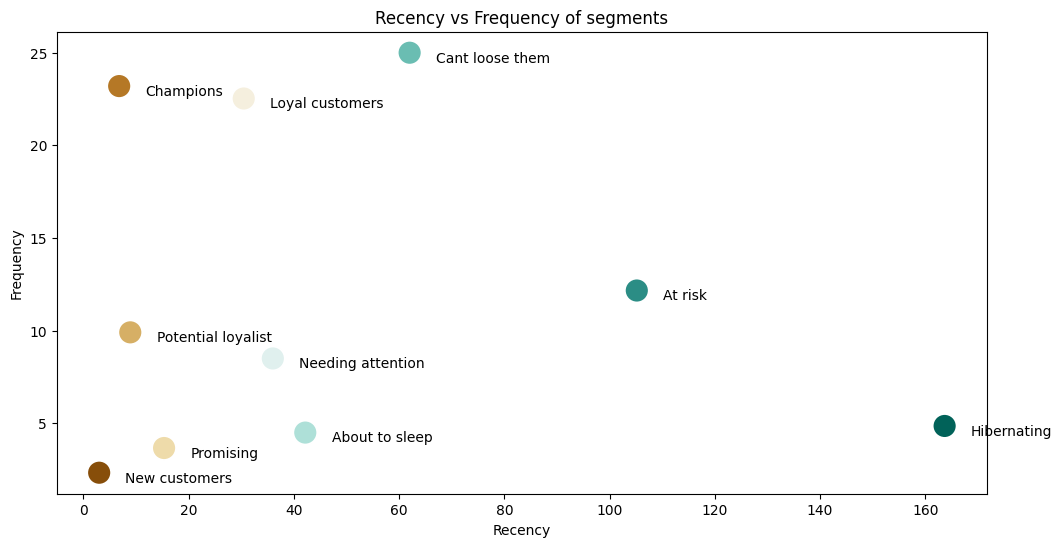

In [48]:
# Recency vs Frequency of Segments

palette = sns.color_palette("BrBG", 10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='Recency', y='Frequency', data=df_analysis, hue='Label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency'][i]+5,
               df_analysis['Frequency'][i]-0.5,
               df_analysis['Label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Frequency of segments')
ax.get_legend().remove()
plt.show()

As expected, scatterplot visualizes the set of rules applied to generate RFM segments. 'Champions' and 'loyal customers' are the ones who buy the most often and who made their last order recently. 'New customers' and 'promising' made purchases not long time ago but they are not frequent buyers yet. And 'hibernating' customers are the ones with the lowest recency and frequency scores.

### Demographic Analysis of RFM segments

In [49]:
df.head()

,OrderID,Order Date,Shipped Date,Customer Name,Country,Product Name,Product Category,Unit Sold,Sales
0,10400,1997-01-01,1997-01-16,Eastern Connection,UK,Thüringer Rostbratwurst,Meat/Poultry,21,2079
1,10400,1997-01-01,1997-01-16,Eastern Connection,UK,Steeleye Stout,Beverages,35,504
2,10400,1997-01-01,1997-01-16,Eastern Connection,UK,Maxilaku,Confections,30,480
3,10401,1997-01-01,1997-01-10,Rattlesnake Canyon Grocery,USA,Nord-Ost Matjeshering,Seafood,18,372
4,10401,1997-01-01,1997-01-10,Rattlesnake Canyon Grocery,USA,Gnocchi di nonna Alice,Grains/Cereals,70,2128


In [50]:
df_rfm.head()

,Customer Name,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_sum,rfm_label,RFM_label
0,Victuailles en stock,0,12,6093,5,3,3,11,,Potential loyalist
1,Franchi S.p.A.,0,6,248,5,2,1,8,,Potential loyalist
2,The Big Cheese,1,4,2955,5,1,2,8,,New customers
3,Wellington Importadora,1,11,4709,5,3,3,11,,Potential loyalist
4,Seven Seas Imports,1,14,9588,5,4,4,13,,Champions


In [51]:
df = df.merge(df_rfm[["Customer Name", "RFM_sum", "RFM_label"]], on="Customer Name", how="left")

In [52]:
df.to_excel('C:\Ayub Indra\Data Analyst\DSLS 2023\Data Engineering\Mini Project\Objective 3 - RFM Analysis\df_result.xlsx', index=False)

In [53]:
df["Country"].unique()

array(['UK', 'USA', 'Austria', 'Italy', 'Venezuela', 'Brazil', 'Germany',
       'France', 'Argentina', 'Canada', 'Finland', 'Denmark',
       'Switzerland', 'Spain', 'Ireland', 'Portugal', 'Sweden', 'Belgium',
       'Mexico', 'Norway', 'Poland'], dtype=object)

In [54]:
country_dict = {
    "USA" : "United States of America",
    "UK" : "United Kingdom",
}

df["Country"] = df["Country"].apply(lambda x: country_dict[x] if x in country_dict.keys() else x)

In [55]:
agg_dict3 = {
    "OrderID" : "nunique",
    "RFM_sum" : "mean"
}

df_country = df.groupby("Country").agg(agg_dict3).reset_index().rename({"OrderID":"Order Count", "RFM_sum":"RFM Mean"}, axis=1)

In [56]:
df_country.to_csv("C:\Ayub Indra\Data Analyst\DSLS 2023\Data Engineering\Mini Project\Objective 3 - RFM Analysis\RFM_Country.csv", index=False)

### Behavioral Analysis of RFM Segments

In this part, let's examine customers' transaction history. Quantity of products in order and sales are highly correlated with each other (linear relationship) - groups of custmers who place orders with numerous products generate big sales at the same time. It implies that average price of one product is similar between segments.

Segments generating the highest sales are: 'can't loose them', 'loyal customers' and 'champions'. They also have high RFM score (dark purple color of a marker) and they are responsible for the highest profit (the biggest size of a marker).

In [57]:
agg_dict4 = {
    'Product Name': 'count',
    'Unit Sold': 'sum',
    'Sales': 'sum',
    'RFM_sum': 'first',
    'RFM_label': 'first'
}

df_order = df.groupby('OrderID').agg(agg_dict4).reset_index()
df_order_segment = df_order.groupby('RFM_label')[['Unit Sold', 'Sales', 'RFM_sum']].mean().reset_index()
df_order.head()

,OrderID,Product Name,Unit Sold,Sales,RFM_sum,RFM_label
0,10400,3,86,3063,7,Hibernating
1,10401,4,168,3868,12,Loyal customers
2,10402,2,125,2713,15,Champions
3,10403,2,91,1004,15,Champions
4,10404,3,100,1672,10,Potential loyalist


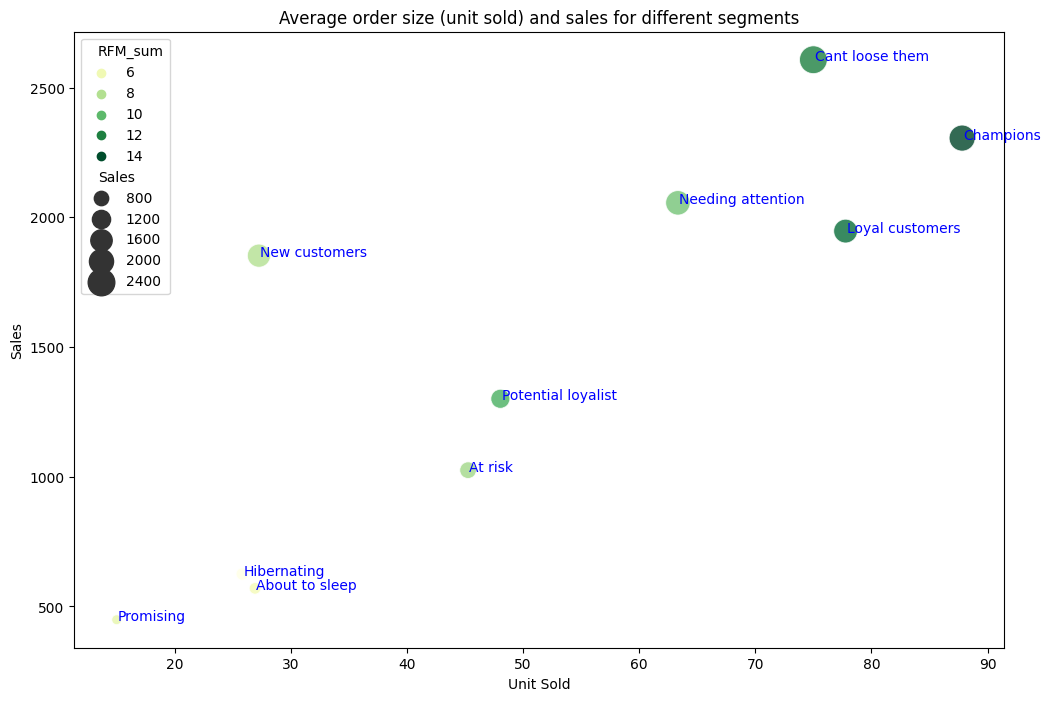

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
plot = sns.scatterplot(x='Unit Sold', y='Sales', data=df_order_segment, size="Sales", sizes=(50,400), hue='RFM_sum', alpha=.8, palette='YlGn')

for i in range(len(df_order_segment)):
     plot.text(df_order_segment['Unit Sold'][i]+0.1,
               df_order_segment['Sales'][i]-4,
               df_order_segment['RFM_label'][i],
               horizontalalignment='left',
               size='medium', color='blue')

ax.set_title('Average order size (unit sold) and sales for different segments')
plt.show()

### Reference
1. https://www.putler.com/rfm-analysis/
2. https://clevertap.com/blog/rfm-analysis/
3. https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
4. https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python
5. https://www.r-bloggers.com/rfm-analysis-in-r/
6. https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
7. https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb